In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from skimage.io import ImageCollection
from pprint import pprint
from skimage import io,transform
import numpy as np

In [2]:
def readAllImages(path):
    img_arr = ImageCollection(path + '/*.tif')
    return img_arr,len(img_arr)

In [3]:
# 读取数据
blank = readAllImages('''dataset/Blank_aug''')
border = readAllImages('''dataset/Border_aug''')
center = readAllImages('''dataset/Center_aug''')

arr1,len1 = blank[0],blank[1]   # 2
arr2,len2 = border[0],border[1]  # 0
arr3,len3 = center[0],center[1] # 1






train_images = []
test_images = []
train_y = []
test_y = []

for i in range(len1):
    if i >= 1000:
        test_images.append(arr1[i])
        test_y.append(2)
    else:
        train_images.append(arr1[i])
        train_y.append(2)

for i in range(len2):
    if i >= 1000:
        test_images.append(arr2[i])
        test_y.append(0)
    else:
        train_images.append(arr2[i])
        train_y.append(0)
        
for i in range(len3):
    if i >= 1000:
        test_images.append(arr3[i])
        test_y.append(1)
    else:
        train_images.append(arr3[i])
        train_y.append(1)
# for i in train_images:
#     print(i.shape)

y_train = np.array(train_y,dtype='int32')
y_test = np.array(test_y,dtype='int32')
x_train = np.stack(train_images,axis=0)
x_test = np.stack(test_images,axis=0)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)



(2714, 20, 20) (866, 20, 20)
(2714,) (866,)


In [4]:
# 数据预处理函数
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32) / 255.
    x = tf.reshape(x, [-1, 32, 32, 1])
    y = tf.one_hot(y, depth=3)  # one_hot 编码
    return x, y

In [5]:
# 样本图像周围补0（上下左右均补6个0），将20*20的图像转成32*32的图像
paddings = tf.constant([[0,0],[6, 6], [6, 6]])
x_train = tf.pad(x_train, paddings)
x_test = tf.pad(x_test, paddings)

x_train.shape, x_test.shape

(TensorShape([2714, 32, 32]), TensorShape([866, 32, 32]))

In [6]:
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_db = train_db.shuffle(10000)  # 打乱训练集样本
train_db = train_db.batch(128)
train_db = train_db.map(preprocess)

test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.shuffle(10000)  # 打乱测试集样本
test_db = test_db.batch(128)
test_db = test_db.map(preprocess)

batch = 32


In [7]:
# 创建模型
model = keras.Sequential([
    # 卷积层1
    keras.layers.Conv2D(6, 5),  # 使用6个5*5的卷积核对单通道32*32的图片进行卷积，结果得到6个28*28的特征图
    keras.layers.MaxPooling2D(pool_size=2, strides=2),  # 对28*28的特征图进行2*2最大池化，得到14*14的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 卷积层2
    keras.layers.Conv2D(16, 5),  # 使用16个5*5的卷积核对6通道14*14的图片进行卷积，结果得到16个10*10的特征图
    keras.layers.MaxPooling2D(pool_size=2, strides=2),  # 对10*10的特征图进行2*2最大池化，得到5*5的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 卷积层3
    keras.layers.Conv2D(120, 5),  # 使用120个5*5的卷积核对16通道5*5的图片进行卷积，结果得到120个1*1的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 将 (None, 1, 1, 120) 的下采样图片拉伸成 (None, 120) 的形状
    keras.layers.Flatten(),
    # 全连接层1
    keras.layers.Dense(84, activation='relu'),  # 120*84
    # 全连接层2
    keras.layers.Dense(3, activation='softmax')  # 84*10
])
model.build(input_shape=(batch, 32, 32, 1))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (32, 28, 28, 6)           156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 14, 14, 6)           0         
_________________________________________________________________
re_lu (ReLU)                 (32, 14, 14, 6)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 10, 10, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 5, 5, 16)            0         
_________________________________________________________________
re_lu_1 (ReLU)               (32, 5, 5, 16)            0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 1, 1, 120)           4

In [8]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['categorical_accuracy'])
# 训练
history = model.fit(train_db, epochs=15)

Epoch 1/15
22/22 [==============================] - 1s 22ms/step - loss: 0.9342 - categorical_accuracy: 0.5279
Epoch 2/15
22/22 [==============================] - 1s 24ms/step - loss: 0.1902 - categorical_accuracy: 0.9377
Epoch 3/15
22/22 [==============================] - 0s 22ms/step - loss: 0.0854 - categorical_accuracy: 0.9702
Epoch 4/15
22/22 [==============================] - 1s 23ms/step - loss: 0.0478 - categorical_accuracy: 0.9877
Epoch 5/15
22/22 [==============================] - 1s 24ms/step - loss: 0.0455 - categorical_accuracy: 0.9809
Epoch 6/15
22/22 [==============================] - 1s 28ms/step - loss: 0.0252 - categorical_accuracy: 0.9960
Epoch 7/15
22/22 [==============================] - 1s 26ms/step - loss: 0.0253 - categorical_accuracy: 0.9925
Epoch 8/15
22/22 [==============================] - 1s 26ms/step - loss: 0.0265 - categorical_accuracy: 0.9912
Epoch 9/15
22/22 [==============================] - 1s 23ms/step - loss: 0.0123 - categorical_accuracy: 0.9978
E

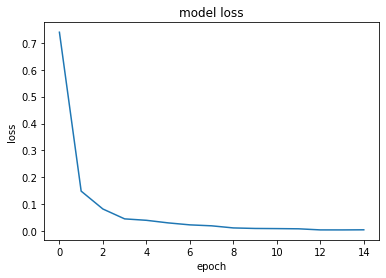

In [9]:
# 损失下降曲线
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [10]:
# 测试
model.evaluate(test_db)

7/7 [==============================] - 0s 11ms/step - loss: 0.0352 - categorical_accuracy: 0.9873


[0.035151854157447815, 0.9872978925704956]

In [11]:
# 保存模型
model.save('lenet-model.h5',overwrite = True, include_optimizer = True)